# 导入库和包

In [2]:
import gym
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from gym import envs
import os

# Q-learning

## Q-learning算法

In [ ]:
class agent_q_learning():
  def __init__(self, env, q_param):
    self.env = env
    if q_param is None:
      self.alpha = 0.5 
      self.gamma = 1
    else:
      self.alpha = q_param['alpha']
      self.gamma =  q_param['gamma']
    self.epsilon = 0.1

    self.q={}
    self.__init_q_table()
    pass

  def output_action(self, state, is_greedy = True):
    if random.uniform(0,1) < self.epsilon and is_greedy:
      return self.env.action_space.sample()
    else:
      return max(list(range(self.env.action_space.n)) ,
                 key=lambda x: self.q[(state,x)])
    pass

  def __init_q_table(self):
    for s in range(self.env.observation_space.n):
      for a in range(self.env.action_space.n):
        self.q[(s,a)]=0.0


  def update_q_table(self, state, action, next_state, next_maxaction, reward, alpha_enhance=0, gamma_enhance=0):
    alpha = self.alpha + alpha_enhance
    gamma = self.gamma + gamma_enhance
    
    self.q[(state,action)] += alpha * \
                        (reward + \
                          gamma * self.q[(next_state,next_maxaction)] - \
                          self.q[(state,action)] \
                          )

## Q-learning原始奖励执行和评估

In [ ]:
class evaluate_alg_q():
  def __init__(self, env, cnt=50, episodes=2000, q_param=None, goal_flag = 0.9):
    #cnt 用作多次求平均值
    self.env = env
    self.cnt = cnt
    self.episodes = episodes
    self.q_param = q_param
    self.goal_flag = goal_flag

    self.reward_array = np.zeros(episodes)
    self.goal_array = np.zeros(episodes)
    self.agent = agent_q_learning(env, self.q_param)
    pass

  def start_execute(self):
    for _ in tqdm(range(self.cnt)):
      self.agent = agent_q_learning(env, self.q_param)

      for i in range(self.episodes):
        r = 0
        state = self.env.reset()
        while True:
          action = self.agent.output_action(state)
          next_state, reward, done , _ = self.env.step(action)
          next_maxaction = self.agent.output_action(state, is_greedy=False)
          self.agent.update_q_table(state, action, next_state, next_maxaction, reward)

          state = next_state
          r += reward

          if done:
            if i >= 1:
              self.goal_array[i] = self.goal_array[i-1] + 1 if reward > self.goal_flag else self.goal_array[i-1] # from reward msg to get whether the goal is get or not
            elif i == 0:
              self.goal_array[0] = 1 if reward > self.goal_flag else 0
            break
          elif reward > self.goal_flag:
            self.goal_array[i] += 1
            
        self.reward_array[i] += r

    self.reward_array /= self.cnt
    self.goal_array /= self.cnt

  def evaluate_plot_reward(self):
    plt.plot(self.reward_array)
  
  def evaluate_plot_reward_dev(self, dev_num=10):
    size_row = int(len(self.reward_array)/dev_num)
    reward_array_dev = self.reward_array.reshape((size_row, dev_num)).mean(axis = 1)
    envaluate_plt = plt.plot(reward_array_dev)
    return envaluate_plt

  def evaluate_plot_goal(self):
    plt.plot(self.goal_array)


100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


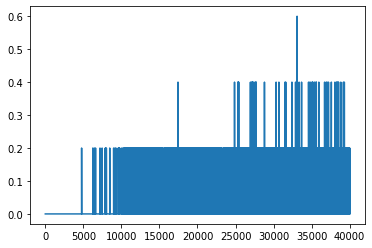

In [ ]:
env = gym.make('FrozenLake-v0')
algorithm_q = evaluate_alg_q(env, cnt=5, episodes=40000)
algorithm_q.start_execute()
algorithm_q.evaluate_plot_reward()
env.close()

上面这张图，拉长后，其线条才会稀疏开，应该是后面的慢慢变密，而不是全部都是成功状态

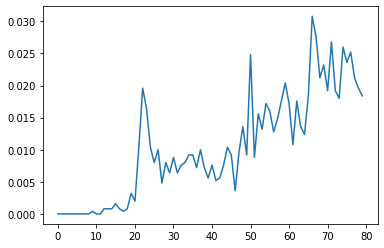

In [ ]:
#reward plot
algorithm_q.evaluate_plot_reward_dev(dev_num=500)

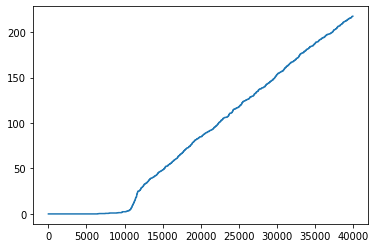

In [ ]:
algorithm_q.evaluate_plot_goal()

## Q-learning修改奖励执行和评估

In [ ]:
class evaluate_alg_rq():
  def __init__(self, env, cnt=50, episodes=2000, q_param=None, goal_flag = 0.9):
    #cnt 用作多次求平均值
    self.env = env
    self.cnt = cnt
    self.episodes = episodes
    self.q_param = q_param
    self.goal_flag = goal_flag

    self.reward_array = np.zeros(episodes)
    self.goal_array = np.zeros(episodes)
    self.agent = agent_q_learning(env, self.q_param)
    pass

  def start_execute(self):
    for _ in tqdm(range(self.cnt)):
      self.agent = agent_q_learning(env, self.q_param)

      for i in range(self.episodes):
        r = 0
        state = self.env.reset()
        while True:
          action = self.agent.output_action(state)
          next_state, reward, done , _ = self.env.step(action)

          # I change this reward to make agent go straight more fast
          reward -= 0.01
          next_maxaction = self.agent.output_action(state, is_greedy=False)
          if reward > self.goal_flag : # from reward msg to get whether the goal is get or not
            self.agent.update_q_table(state, action, next_state, next_maxaction, reward + 10,  alpha_enhance=0.5, gamma_enhance=0.2)
          else:
            self.agent.update_q_table(state, action, next_state ,next_maxaction, reward)
          
          state = next_state
          r += reward

          if done:
            if i >= 1:
              self.goal_array[i] = self.goal_array[i-1] + 1 if reward > self.goal_flag else self.goal_array[i-1] # from reward msg to get whether the goal is get or not
            elif i == 0:
              self.goal_array[0] = 1 if reward > self.goal_flag else 0
            break
          elif reward > self.goal_flag:
            self.goal_array[i] += 1

        self.reward_array[i] += r
      
    self.reward_array /= self.cnt
    self.goal_array /= self.cnt

  def evaluate_plot_reward(self):
    plt.plot(self.reward_array)
  
  def evaluate_plot_reward_dev(self, dev_num=10):
    size_row = int(len(self.reward_array)/dev_num)
    reward_array_dev = self.reward_array.reshape((size_row, dev_num)).mean(axis = 1)
    envaluate_plt = plt.plot(reward_array_dev)
    return envaluate_plt

  def evaluate_plot_goal(self):
    plt.plot(self.goal_array)


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


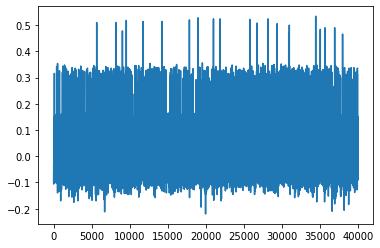

In [ ]:
env = gym.make('FrozenLake-v0')
algorithm_rq = evaluate_alg_rq(env, cnt=5, episodes=40000)
algorithm_rq.start_execute()
algorithm_rq.evaluate_plot_reward()
env.close()

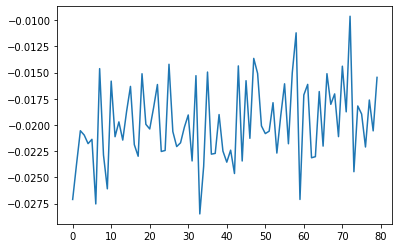

In [ ]:
algorithm_rq.evaluate_plot_reward_dev(dev_num=500)

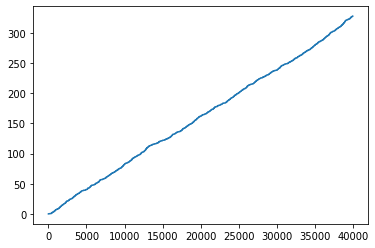

In [ ]:
algorithm_rq.evaluate_plot_goal()

## 联合对比

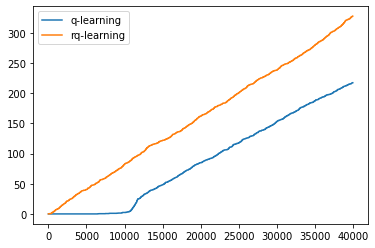

In [ ]:
algorithm_q.evaluate_plot_goal()
algorithm_rq.evaluate_plot_goal()
plt.legend(['q-learning', 'rq-learning'])

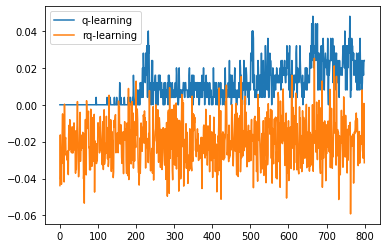

In [ ]:
algorithm_q.evaluate_plot_reward_dev(dev_num=50)
algorithm_rq.evaluate_plot_reward_dev(dev_num=50)
plt.legend(['q-learning', 'rq-learning'])

# 工具项

## 手动玩

### FrozenLake-v0
https://github.com/openai/gym/wiki/FrozenLake-v0

0	Move Left

1	Move Down

2	Move Right

3	Move Up

In [1]:
env =gym.make('Taxi-v3')
state = env.reset()
print(state)
for i in range(100):
  env.render()
  action = input('action:')
  action = int(action)
  next_state, reward, done, info = env.step(action)
  print('all msg:',next_state, reward, done, info)


NameError: ignored

### NChain-v0

In [ ]:
env =gym.make('NChain-v0')
state = env.reset()
print(state)
for i in range(1000):
  os.system('clear')
  action = input('action:')
  action = int(action)
  # action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)

  print('all msg:',next_state, reward, done, info)

0
all msg: 2 0 True {'TimeLimit.truncated': True}


### 说明
下面这张是应用Q-learning在冰冻湖上的问题。以奖励进行度量时，由于其奖励的稀疏性，看不到学习效果。只有从长期看，才能得到其完成情况。

因此这里，使用目标完成个数累积，作为算法收敛性判断依据，比直接用奖励进行判断要好。

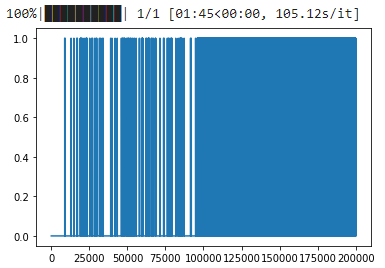

## 其它环境的拓展测试

|  其它环境   | 奖励标记作为任务完成  |
|:---------------:|:----------------:|
|   NChain-v0  | 9 |
| FrozenLake-v0  | 0.9 |
| FrozenLake8x8-v0  | 0.9 |
| Roulette-v0  | 30 |


### FrozenLake 8X8

In [ ]:
env = gym.make('FrozenLake8x8-v0')
algorithm_q = evaluate_alg_q(env, cnt=5, episodes=4000)
algorithm_q.start_execute()
algorithm_rq = evaluate_alg_rq(env, cnt=5, episodes=4000)
algorithm_rq.start_execute()
env.close()


100%|██████████| 5/5 [00:38<00:00,  7.60s/it]

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


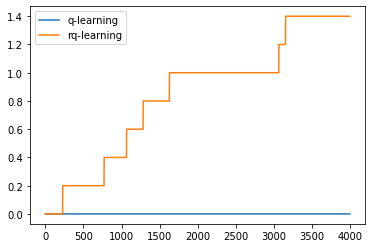

In [ ]:
algorithm_q.evaluate_plot_goal()
algorithm_rq.evaluate_plot_goal()
plt.legend(['q-learning', 'rq-learning'])

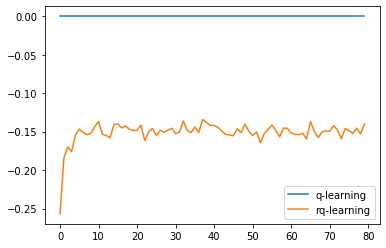

In [ ]:
algorithm_q.evaluate_plot_reward_dev(dev_num=50)
algorithm_rq.evaluate_plot_reward_dev(dev_num=50)
plt.legend(['q-learning', 'rq-learning'])

### NChain-v0

这个环境要多跑几次才好，效果不佳，又要出好图的话

In [ ]:
env = gym.make('NChain-v0')
algorithm_q = evaluate_alg_q(env, cnt=10, episodes=500, goal_flag = 9)
algorithm_q.start_execute()
algorithm_rq = evaluate_alg_rq(env, cnt=10, episodes=500, goal_flag = 9)
algorithm_rq.start_execute()
env.close()

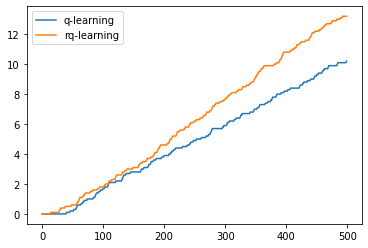

In [ ]:
algorithm_q.evaluate_plot_goal()
algorithm_rq.evaluate_plot_goal()
plt.legend(['q-learning', 'rq-learning'])

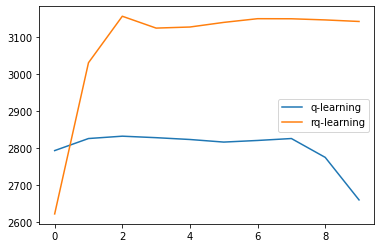

In [ ]:
algorithm_q.evaluate_plot_reward_dev(dev_num=50)
algorithm_rq.evaluate_plot_reward_dev(dev_num=50)
plt.legend(['q-learning', 'rq-learning'])

### Roulette-v0

In [ ]:
env = gym.make('Roulette-v0')
algorithm_q = evaluate_alg_q(env, cnt=10, episodes=5000, goal_flag = 30)
algorithm_q.start_execute()
algorithm_rq = evaluate_alg_rq(env, cnt=10, episodes=5000, goal_flag = 30)
algorithm_rq.start_execute()
env.close()

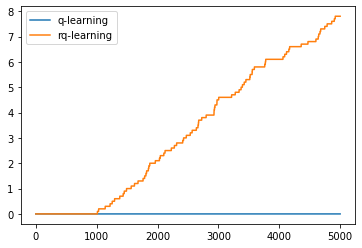

In [ ]:
algorithm_q.evaluate_plot_goal()
algorithm_rq.evaluate_plot_goal()
plt.legend(['q-learning', 'rq-learning'])

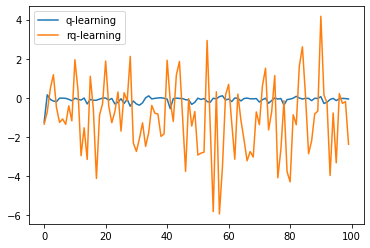

In [ ]:
algorithm_q.evaluate_plot_reward_dev(dev_num=50)
algorithm_rq.evaluate_plot_reward_dev(dev_num=50)
plt.legend(['q-learning', 'rq-learning'])

# 文档结尾

这个想法其实没什么用，但是更改了奖励机制对解决实际问题确实是有帮助的。（如果要机器和人一样操作的话）

白梦伟